In [1]:
import numpy as np
import matplotlib.pyplot as plt

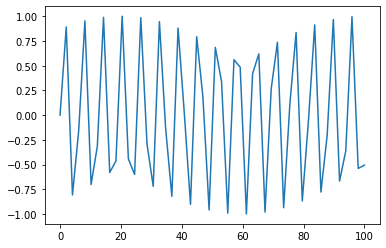

In [6]:
X = np.linspace(0, 100)
_ = plt.plot(X, np.sin(X))